In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString , Polygon


import csv
from pathlib import Path

import rasterio
import rasterio.mask
from rasterio.plot import show_hist
from rasterio.plot import show

import rasterstats
from descartes import PolygonPatch


import geojson
from shapely.geometry import Point, mapping, shape
from fiona import collection
import fiona

import geoplot 

from rasterstats import zonal_stats

from shape_generator import select_raster_file

## Pseudo code program design

- get list off all cyclones (inside this notebook)
- create empty list "cyclone_population_data"
    - for each cyclone create a "shifted dataframe" (-> Geetha)
    - for each cyclone create a list of dictionaries "single_cyclone"
    - for each cyclone get the correct input raster_file for the correct year (-> Vamsi)
    - for each cyclone create buffered path depending on windspeed (currently working on best cyclone shape) (->Geetha & Susanne)
         - for each windspeed detect the affected countries
         - for each affected country create intersection shape
             - generate population based on this intersection shape and input raster_file
             - append dict of (cyclone_name, cyclone_year, windspeed, population) to one_cyclone_list
    - for each cyclone tranform the "single_cyclone" list of dicts to a single line (-> TODO!)
    - append this line to "cyclone_population_data"
- create dataframe from "cyclone_population_data"
- pickle dataframe to file

## Setting up the data files

In [6]:
# reading in the cyclone data
data_folder = Path.cwd().parent.parent.joinpath('datasets') 
#print(data_folder)
#input_filename = 'epac-atl.csv'
input_filename = 'ibtrax.csv'
input_file = Path(data_folder).joinpath(input_filename)
print(input_file)

G:\Omdena\wfpdisrel\#task1-datacollection\datasets\ibtrax.csv


In [14]:
# reading in the Gridded Population of the World dataset
data_folder = Path.cwd().parent.parent.joinpath('datasets', 'Gridded Population of the World (GPW)')
#print(data_folder)
input_filename = 'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2015.tif'
input_raster_file = Path(data_folder).joinpath(input_filename)
print(input_raster_file)

G:\Omdena\wfpdisrel\#task1-datacollection\datasets\Gridded Population of the World (GPW)\gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2015.tif


In [15]:
# get the countries associated for the geometry boundary's
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [16]:
df_input = pd.read_csv(input_file)  
df_input.columns

Index(['Unnamed: 0', 'SID', 'NAME', 'SEASON', 'LON', 'LAT', 'max_34', 'max_50',
       'max_64', 'SID_1', 'SID_2', 'max_34_1', 'max_50_1', 'max_64_1'],
      dtype='object')

In [17]:
df_input.rename(columns = {'NAME':'name', 'SEASON': 'year', 'LON': 'long', 'LAT':'lat'}, inplace = True) 
df_input.columns

Index(['Unnamed: 0', 'SID', 'name', 'year', 'long', 'lat', 'max_34', 'max_50',
       'max_64', 'SID_1', 'SID_2', 'max_34_1', 'max_50_1', 'max_64_1'],
      dtype='object')

## Create list of cyclones by name and year

In [19]:
cyclones = df_input.groupby(['name','year'], as_index = False).sum()
#cyclones = df_input.groupby(['id','name','year'], as_index = False).sum()
cyclones = cyclones[['name', 'year']]
print(cyclones)

      name  year
0      ABE  1990
1      ABE  1993
2     ADEL  1993
3     AERE  2004
4     AERE  2011
..     ...   ...
772    ZEB  1998
773   ZEKE  1991
774   ZENA  2016
775   ZITA  1997
776  ZUMAN  1998

[777 rows x 2 columns]


## Population extraction for a single cyclone - step by step

In [21]:
cyclone_name = 'IVAN'
cyclone_year = 2004

In [26]:
windspeeds = ['max_34','max_50', 'max_64']
windspeed = 'max_34'

### Create a dataset for a single cyclone

In [28]:
cyclone_df = df_input[(df_input.year==cyclone_year) & (df_input.name == cyclone_name)].copy()
cyclone_df

,Unnamed: 0,SID,name,year,long,lat,max_34,max_50,max_64,SID_1,SID_2,max_34_1,max_50_1,max_64_1
39762,378376,2004247N10332,IVAN,2004,-27.60,9.70,50.0,25.0,20.0,2004247N10332,2004247N10332,50.0,25.0,20.0
39763,378377,2004247N10332,IVAN,2004,-28.11,9.70,50.0,25.0,20.0,2004247N10332,2004247N10332,50.0,25.0,20.0
39764,378378,2004247N10332,IVAN,2004,-28.70,9.70,50.0,25.0,20.0,2004247N10332,2004247N10332,50.0,25.0,20.0
39765,378379,2004247N10332,IVAN,2004,-29.45,9.71,50.0,25.0,20.0,2004247N10332,2004247N10332,50.0,25.0,20.0
39766,378380,2004247N10332,IVAN,2004,-30.30,9.70,50.0,25.0,20.0,2004247N10332,2004247N10332,50.0,25.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39935,378549,2004247N10332,IVAN,2004,-92.70,29.20,50.0,20.0,45.0,2004247N10332,2004247N10332,50.0,20.0,45.0
39936,378550,2004247N10332,IVAN,2004,-92.87,29.37,50.0,20.0,45.0,2004247N10332,2004247N10332,50.0,20.0,45.0
39937,378551,2004247N10332,IVAN,2004,-93.20,29.60,50.0,20.0,45.0,2004247N10332,2004247N10332,50.0,20.0,45.0
39938,378552,2004247N10332,IVAN,2004,-93.60,29.80,50.0,20.0,45.0,2004247N10332,2004247N10332,50.0,20.0,45.0


In [29]:
def create_shifted_dataset(df):
    my_cyclone = df[['name','year','lat','long', 'max_34', 'max_50', 'max_64']].copy()
    my_cyclone['lat_1']= my_cyclone['lat'].shift(-1)
    my_cyclone['long_1']= my_cyclone['long'].shift(-1)
    my_cyclone = my_cyclone.dropna()
    return my_cyclone

In [30]:
single_cyclone_df= create_shifted_dataset(cyclone_df)
single_cyclone_df

,name,year,lat,long,max_34,max_50,max_64,lat_1,long_1
39762,IVAN,2004,9.70,-27.60,50.0,25.0,20.0,9.70,-28.11
39763,IVAN,2004,9.70,-28.11,50.0,25.0,20.0,9.70,-28.70
39764,IVAN,2004,9.70,-28.70,50.0,25.0,20.0,9.71,-29.45
39765,IVAN,2004,9.71,-29.45,50.0,25.0,20.0,9.70,-30.30
39766,IVAN,2004,9.70,-30.30,50.0,25.0,20.0,9.62,-31.21
...,...,...,...,...,...,...,...,...,...
39934,IVAN,2004,29.09,-92.50,55.0,20.0,45.0,29.20,-92.70
39935,IVAN,2004,29.20,-92.70,50.0,20.0,45.0,29.37,-92.87
39936,IVAN,2004,29.37,-92.87,50.0,20.0,45.0,29.60,-93.20
39937,IVAN,2004,29.60,-93.20,50.0,20.0,45.0,29.80,-93.60


In [31]:
def create_cyclone_gdf(df):
    df['point_0'] = df.apply(lambda row: Point(row.long, row.lat), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='point_0') #, crs={'init': 'epsg:4326'})  # deprecated version
    gdf.crs =  "EPSG:4326"
    gdf['point_1']  = gdf.apply(lambda row: Point(row.long_1, row.lat_1), axis=1)
    gdf['line']  = gdf.apply(lambda row: LineString((row["point_0"], row["point_1"])), axis=1)
    return gdf

### Create GeoPandasDataFrame for single cyclone

In [32]:
cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
cyclone_gdf

,name,year,lat,long,max_34,max_50,max_64,lat_1,long_1,point_0,point_1,line
39762,IVAN,2004,9.70,-27.60,50.0,25.0,20.0,9.70,-28.11,POINT (-27.60000 9.70000),POINT (-28.11 9.699999999999999),"LINESTRING (-27.6 9.699999999999999, -28.11 9...."
39763,IVAN,2004,9.70,-28.11,50.0,25.0,20.0,9.70,-28.70,POINT (-28.11000 9.70000),POINT (-28.7 9.699999999999999),"LINESTRING (-28.11 9.699999999999999, -28.7 9...."
39764,IVAN,2004,9.70,-28.70,50.0,25.0,20.0,9.71,-29.45,POINT (-28.70000 9.70000),POINT (-29.45 9.710000000000001),"LINESTRING (-28.7 9.699999999999999, -29.45 9...."
39765,IVAN,2004,9.71,-29.45,50.0,25.0,20.0,9.70,-30.30,POINT (-29.45000 9.71000),POINT (-30.3 9.699999999999999),"LINESTRING (-29.45 9.710000000000001, -30.3 9...."
39766,IVAN,2004,9.70,-30.30,50.0,25.0,20.0,9.62,-31.21,POINT (-30.30000 9.70000),POINT (-31.21 9.619999999999999),"LINESTRING (-30.3 9.699999999999999, -31.21 9...."
...,...,...,...,...,...,...,...,...,...,...,...,...
39934,IVAN,2004,29.09,-92.50,55.0,20.0,45.0,29.20,-92.70,POINT (-92.50000 29.09000),POINT (-92.7 29.2),"LINESTRING (-92.5 29.09, -92.7 29.2)"
39935,IVAN,2004,29.20,-92.70,50.0,20.0,45.0,29.37,-92.87,POINT (-92.70000 29.20000),POINT (-92.87 29.37),"LINESTRING (-92.7 29.2, -92.87 29.37)"
39936,IVAN,2004,29.37,-92.87,50.0,20.0,45.0,29.60,-93.20,POINT (-92.87000 29.37000),POINT (-93.2 29.6),"LINESTRING (-92.87 29.37, -93.2 29.6)"
39937,IVAN,2004,29.60,-93.20,50.0,20.0,45.0,29.80,-93.60,POINT (-93.20000 29.60000),POINT (-93.59999999999999 29.8),"LINESTRING (-93.2 29.6, -93.59999999999999 29.8)"


In [37]:
def plot_cyclone_on_partial_worldmap(gdf):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    xmin, ymin, xmax, ymax = gdf.total_bounds
    partial_world= world.cx[xmin:xmax, ymin:ymax]
 
    fig, ax = plt.subplots()
    #fig, ax = plt.subplots(figsize=(10, 10))
    partial_world.plot(ax=ax, color="#cccccc")
    gdf.plot(ax=ax, markersize=5, color="#cc0000")
    plt.show()

### Create a buffer of the GeoPandasDataFrame according to the radii of the given windspeed

In [73]:
def bufer_max_output(df,wind_speed):
    df = df.set_geometry('point_0')
    df = df.to_crs('epsg:3395')
    buffer_fact = 1825          # dimensions are in nautic miles, buffering is done in meters
    df['buf_center_{}'.format(wind_speed)] = df.apply(lambda x: x.point_0.buffer(x[wind_speed] * buffer_fact) , axis=1)
    df = df.set_geometry('buf_center_{}'.format(wind_speed))
    df = df.to_crs('epsg:4326')
    df = df.set_geometry('line')
    df = df.to_crs('epsg:3395')
    df['buf_line_{}'.format(wind_speed)] = df.apply(lambda x: x.point_0.buffer(x[wind_speed] * buffer_fact) , axis=1)
    df = df.set_geometry('buf_line_{}'.format(wind_speed))
    df = df.to_crs('epsg:4326')
    df = gpd.GeoDataFrame(df, geometry='buf_line_{}'.format(wind_speed))
    df.crs = 'epsg:4326'                      
    return df
buffer_gdf = bufer_max_output(cyclone_gdf,'max_34')
buffer_gdf

,name,year,lat,long,max_34,max_50,max_64,lat_1,long_1,point_0,point_1,line,buf_center_max_34,buf_line_max_34
98,JANE,1950,23.10,140.10,159.0,30.0,15.0,23.21,140.00,POINT (15595860.660 2627358.795),POINT (140 23.21),"LINESTRING (15595860.660 2627358.795, 15584728...","POLYGON ((142.70669 23.10000, 142.69413 22.863...","POLYGON ((142.70669 23.10000, 142.69413 22.863..."
99,JANE,1950,23.21,140.00,159.0,30.0,15.0,23.30,139.90,POINT (15584728.711 2640601.330),POINT (139.9 23.3),"LINESTRING (15584728.711 2640601.330, 15573596...","POLYGON ((142.60669 23.21000, 142.59413 22.973...","POLYGON ((142.60669 23.21000, 142.59413 22.973..."
100,JANE,1950,23.30,139.90,159.0,30.0,15.0,23.35,139.80,POINT (15573596.762 2651444.333),POINT (139.8 23.35),"LINESTRING (15573596.762 2651444.333, 15562464...","POLYGON ((142.50669 23.30000, 142.49413 23.063...","POLYGON ((142.50669 23.30000, 142.49413 23.063..."
101,JANE,1950,23.35,139.80,159.0,30.0,15.0,23.40,139.70,POINT (15562464.813 2657471.428),POINT (139.7 23.4),"LINESTRING (15562464.813 2657471.428, 15551332...","POLYGON ((142.40669 23.35000, 142.39413 23.113...","POLYGON ((142.40669 23.35000, 142.39413 23.113..."
102,JANE,1950,23.40,139.70,159.0,30.0,15.0,23.50,139.60,POINT (15551332.864 2663500.819),POINT (139.6 23.5),"LINESTRING (15551332.864 2663500.819, 15540200...","POLYGON ((142.30669 23.40000, 142.29413 23.163...","POLYGON ((142.30669 23.40000, 142.29413 23.163..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,JANE,1950,48.00,160.20,159.0,30.0,15.0,48.29,162.74,POINT (17833382.425 6075085.090),POINT (162.74 48.29),"LINESTRING (17833382.425 6075085.090, 18116133...","POLYGON ((162.80669 48.00000, 162.79413 47.828...","POLYGON ((162.80669 48.00000, 162.79413 47.828..."
161,JANE,1950,48.29,162.74,159.0,30.0,15.0,48.50,166.00,POINT (18116133.932 6123322.339),POINT (166 48.5),"LINESTRING (18116133.932 6123322.339, 18479035...","POLYGON ((165.34669 48.29000, 165.33413 48.119...","POLYGON ((165.34669 48.29000, 165.33413 48.119..."
162,JANE,1950,48.50,166.00,159.0,30.0,15.0,48.59,168.74,POINT (18479035.472 6158425.025),POINT (168.74 48.59),"LINESTRING (18479035.472 6158425.025, 18784050...","POLYGON ((168.60669 48.50000, 168.59413 48.329...","POLYGON ((168.60669 48.50000, 168.59413 48.329..."
163,JANE,1950,48.59,168.74,159.0,30.0,15.0,48.70,171.50,POINT (18784050.876 6173513.808),POINT (171.5 48.7),"LINESTRING (18784050.876 6173513.808, 19091292...","POLYGON ((171.34669 48.59000, 171.33413 48.420...","POLYGON ((171.34669 48.59000, 171.33413 48.420..."


### Create the outline of the shape for the given windspeed

In [74]:
def create_buffered_shape(buffer_gdf, wind_speed):
    # requires buffer_gdf that was buffered to the according windspeed!
    buffer_gdf.set_geometry('buf_center_{}'.format(wind_speed), inplace=True)
    center_shape = buffer_gdf['buf_center_{}'.format(wind_speed)].unary_union
    buffer_gdf.set_geometry('buf_line_{}'.format(wind_speed), inplace=True)
    line_shape = buffer_gdf['buf_line_{}'.format(wind_speed)].unary_union
    outline = line_shape.intersection(center_shape)  # combine bufferd center and buffered line
    shape_gdf = GeoDataFrame( geometry = [outline])
    return shape_gdf

In [75]:
max_34_shape = create_buffered_shape(buffer_gdf, 'max_34')
max_34_shape

,geometry
0,"POLYGON ((142.70669 23.10000, 142.69413 22.863..."


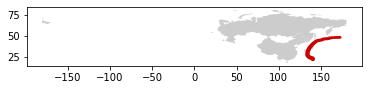

In [76]:
plot_cyclone_on_partial_worldmap(max_34_shape)

In [77]:
def get_buffered_shape(gdf, windspeed):
    buffer_gdf = bufer_max_output(gdf,windspeed)
    buffered_shape = create_buffered_shape(buffer_gdf, windspeed)
    return buffered_shape

In [78]:
shape = get_buffered_shape(cyclone_gdf, 'max_34')
shape.crs = 'epsg:4326'
shape

,geometry
0,"POLYGON ((142.70669 23.10000, 142.69413 22.863..."


### Determine the affected countries for a cyclone depending on the windspeed shape

In [79]:
affected_countries = gpd.overlay(world, shape, how='intersection')
affected_countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,126451398,Asia,Japan,JPN,4932000.0,"MULTIPOLYGON (((144.61343 43.96088, 145.32083 ..."


### Get the affected population

In [80]:
def get_population_by_windspeed(cyclone_name, cyclone_year, affected_countries, windspeed):
    stats = ['sum']
    raster_file = select_raster_file(cyclone_year, input_file)
    cyclone_data = []
    for i in range (len(affected_countries)):   
        cyclone = {}
        country = affected_countries.iloc[i]['name']
        iso = affected_countries.iloc[i]['iso_a3']
        population = zonal_stats(affected_countries.iloc[i].geometry, input_raster_file, stats = stats)[0]['sum']
        cyclone['name'] = cyclone_name
        cyclone['year'] = cyclone_year
        cyclone['country'] = country
        cyclone['iso_a3'] = iso
        cyclone['pop_{}'.format(windspeed)] = population   ## TODO: create population for different windspeeds
        cyclone_data.append(cyclone)
    return cyclone_data

In [81]:
cyclone_data_windspeed = get_population_by_windspeed(cyclone_name, cyclone_year, affected_countries, windspeed)
cyclone_data_windspeed

[{'name': 'AGNES',
  'year': 1984,
  'country': 'Japan',
  'iso_a3': 'JPN',
  'pop_max_34': 62071952.0}]

In [82]:
# Combining the different outputs into a single dataframe
cyclone_pop_df = pd.DataFrame(cyclone_data_windspeed)
data = cyclone_pop_df.groupby(['name','year', 'country'], as_index = False).sum()
data

,name,year,country,pop_max_34
0,AGNES,1984,Japan,62071952.0


## Summary of the code above for a single cyclone

In [83]:
cyclone_year = 1950
cyclone_name = 'JANE'
windspeed = 'max_34'
#windspeed = 'max_50'
#windspeed = 'max_64'
cyclone_df = df_input[(df_input.year==cyclone_year) & (df_input.name == cyclone_name)].copy()
single_cyclone_df= create_shifted_dataset(cyclone_df)
cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
shape = get_buffered_shape(cyclone_gdf, windspeed)
shape.crs = 'epsg:4326'
affected_countries = gpd.overlay(world, shape, how='intersection')
cyclone_data_windspeed = get_population_by_windspeed(cyclone_name, cyclone_year, affected_countries, windspeed)
cyclone_data_windspeed

[{'name': 'JANE',
  'year': 1950,
  'country': 'Japan',
  'iso_a3': 'JPN',
  'pop_max_34': 62071952.0}]

In [84]:
def get_population_by_cyclone(cylone_name, cyclone_year):    
    single_cyclone_data = []
    cyclone_df = df_input[(df_input.year==cyclone_year) & (df_input.name == cyclone_name)].copy()
    single_cyclone_df= create_shifted_dataset(cyclone_df)
    cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
    for windspeed in windspeeds:
        shape = get_buffered_shape(cyclone_gdf, windspeed)
        shape.crs = 'epsg:4326'
        affected_countries = gpd.overlay(world, shape, how='intersection')
        cyclone_data_windspeed = get_population_by_windspeed(cyclone_name, cyclone_year,affected_countries, windspeed)
        single_cyclone_data.extend(cyclone_data_windspeed)
        #print(cyclone_data_windspeed)
    return single_cyclone_data

In [85]:
example_pop = get_population_by_cyclone('JANE', 1950)
example_pop

[{'name': 'JANE',
  'year': 1950,
  'country': 'Japan',
  'iso_a3': 'JPN',
  'pop_max_34': 62071952.0},
 {'name': 'JANE',
  'year': 1950,
  'country': 'Japan',
  'iso_a3': 'JPN',
  'pop_max_50': 14551006.0},
 {'name': 'JANE',
  'year': 1950,
  'country': 'Japan',
  'iso_a3': 'JPN',
  'pop_max_64': 4093306.5}]

## Creating population data for all cyclones

In [86]:
cyclone_data = []
error_cyclone = []
for i in range (10):                  
#for i in range (len(cyclones)):             ## Change here to get output for all cyclones
    cyclone = {}
    cyclone_name = (cyclones.iloc[i]['name'])
    cyclone_year = (cyclones.iloc[i]['year'])
    print(f'Getting population for {cyclone_name} - {cyclone_year}')
    try:
        cyclone_data.extend(get_population_by_cyclone(cyclone_name, cyclone_year))
    except:
        print(f'Error for cyclone {cyclone_name} - {cyclone_year}')
        error_cyclone.append((cyclone_name, cyclone_year))
cyclone_pop = pd.DataFrame(cyclone_data)
summary_df = cyclone_pop.groupby(['name','year', 'country'], as_index = False).sum()
summary_df

Getting population for ABE - 1990
Getting population for ABE - 1993
Getting population for ADEL - 1993
Getting population for AERE - 2004
Getting population for AERE - 2011
Getting population for AERE - 2016
Getting population for AGATHA - 2010
Getting population for AGNES - 1978
Getting population for AGNES - 1981
Getting population for AGNES - 1984


,name,year,country,pop_max_34,pop_max_50,pop_max_64
0,ABE,1990,China,1.745396e+08,1.204653e+08,1.610058e+07
1,ABE,1990,Japan,2.520778e+06,9.158328e+03,0.000000e+00
2,ABE,1990,North Korea,1.798621e+07,4.666184e+06,9.304850e+04
3,ABE,1990,South Korea,3.397186e+07,2.582432e+07,2.039125e+05
4,ABE,1990,Taiwan,9.347849e+06,9.319451e+06,0.000000e+00
5,ABE,1993,China,1.461465e+08,1.696355e+07,5.694372e+06
6,ABE,1993,Philippines,1.345976e+07,1.665186e+06,4.289047e+05
7,ABE,1993,Taiwan,3.903890e+06,0.000000e+00,0.000000e+00
8,ADEL,1993,Australia,2.594380e+03,0.000000e+00,0.000000e+00
9,ADEL,1993,Papua New Guinea,1.532263e+06,2.944409e+05,1.032701e+05


In [33]:
summary_df.to_pickle("../data/population_by_cyclone_sm.pkl")

## Check cyclones that caused geometric errors

In [36]:
error_cyclone

[('AMI', 2003),
 ('IVY', 2004),
 ('KOMPASU', 2010),
 ('OSCAR', 1983),
 ('SARAH', 1983),
 ('VAL', 1975)]

In [35]:
unpickled = pd.read_pickle("../data/population_by_cyclone_sm.pkl")
unpickled

,name,year,country,pop_max_34,pop_max_50,pop_max_64
0,ABE,1990,China,1.250191e+08,6.021144e+07,4.563023e+06
1,ABE,1990,Japan,1.331395e+05,0.000000e+00,0.000000e+00
2,ABE,1990,North Korea,5.992862e+06,1.739038e+06,2.578181e+04
3,ABE,1990,South Korea,2.710072e+07,1.016127e+07,4.097968e+04
4,ABE,1993,China,8.831374e+07,6.822828e+06,1.832642e+06
...,...,...,...,...,...,...
2077,ZITA,1997,Laos,4.145991e+05,6.370109e+03,0.000000e+00
2078,ZITA,1997,Vietnam,3.210241e+07,1.799852e+07,1.955297e+06
2079,ZUMAN,1998,New Caledonia,1.870109e+05,3.948126e+00,0.000000e+00
2080,ZUMAN,1998,New Zealand,2.231758e+03,2.527314e+03,0.000000e+00
